<a href="https://colab.research.google.com/github/namoshi/dl_intro/blob/master/lab_tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2.Auto Encoder

AutoEncoder generally performs learning to minimize mean squared errors between input and output.

Thus, the output of the AutoEncoder is the same as the input.

The features of the hidden layer are applied to various tasks.

※If you want to perform learning, create a source file.

Import of required library.

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from skimage import io

print('torch version is {}'.format(torch.__version__))
if (torch.cuda.is_available):
    print('Cuda is available')
else:
    print('Cuda is not avaibalbe')

torch version is 1.0.0
Cuda is available


Fixed seed value for random numbers.

In [0]:
torch.cuda.manual_seed_all(100100)
torch.manual_seed(100100)
np.random.seed(100100)

Parameter definition.

In [0]:
BATCH_SIZE      = 1000
WEIGHT_DECAY    = 0.001
LEARNING_RATE   = 0.01
EPOCH           = 500
NUM_WORKERS     = 2

Reading dataset.

In [0]:
mnist_train = dsets.MNIST(".", download=True, train=True)
dataTrain = []
dataTest = []


mnist_test = dsets.MNIST(".", download=True, train=False)



for i in range(len(mnist_train)):
    dataTrain.append(np.array(mnist_train[i][0]))


for i in range(len(mnist_test)):
    dataTest.append(np.array(mnist_test[i][0]))

#Change shape to (N, C, H, W) by reshape.
dataTrain = np.array(dataTrain)
dataTrain = dataTrain.reshape(len(mnist_train), 1, 28, 28)
dataTrain = dataTrain / 255.0

dataTest = np.array(dataTest)
dataTest = dataTest.reshape(len(mnist_test), 1, 28, 28)
dataTest = dataTest / 255.0

datasizeTrain = len(dataTrain)
datasizeTest  = len(dataTest)

Define the model structure.

In this example, a multi-layer perceptron having 10 units in hidden layer is used.

In [0]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(28*28*1, 10)
        self.fc2 = nn.Linear(10, 28*28*1)

    def forward(self, x):
        x = x.view(-1, 28*28*1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = x.view(BATCH_SIZE, 1, 28, 28)
        return x
      

net = Network()
if torch.cuda.is_available():
    net.to('cuda')

Define loss and optimizer.

In [0]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=WEIGHT_DECAY)

Input data into the model for each mini-batch and perform parameter update.

In [0]:
trainLoss = []
testLoss  = []


for epoch in range(1, EPOCH+1):
    if (epoch % 10 == 0):
        print("epoch", epoch, "iter", epoch*(datasizeTrain//BATCH_SIZE))

    net.train()
    for i in range(0, datasizeTrain, BATCH_SIZE):
        perm = np.random.permutation(datasizeTrain)
        xBatch = dataTrain[perm[i:i+BATCH_SIZE]]
        tBatch = dataTrain[perm[i:i+BATCH_SIZE]]
        if torch.cuda.is_available():
            xBatch = torch.from_numpy(xBatch.copy()).float().to('cuda')
            tBatch = torch.from_numpy(tBatch.copy()).float().to('cuda')
        else:
            xBatch = torch.from_numpy(xBatch.copy()).float()
            tBatch = torch.from_numpy(tBatch.copy()).float()
        optimizer.zero_grad()
        yBatch = net(xBatch)
        loss = criterion(yBatch, tBatch)
        loss.backward()
        optimizer.step()

    net.eval()
    sumTrainLoss = 0.0
    with torch.no_grad():
        for i in range(0, datasizeTrain, BATCH_SIZE):
            perm = np.random.permutation(datasizeTrain)
            xBatch = dataTrain[perm[i:i+BATCH_SIZE]]
            tBatch = dataTrain[perm[i:i+BATCH_SIZE]]
            if torch.cuda.is_available():
                xBatch = torch.from_numpy(xBatch.copy()).float().to('cuda')
                tBatch = torch.from_numpy(tBatch.copy()).float().to('cuda')
            else:
                xBatch = torch.from_numpy(xBatch.copy()).float()
                tBatch = torch.from_numpy(tBatch.copy()).float()
            yBatch = net(xBatch)
            loss = criterion(yBatch, tBatch)
            if torch.cuda.is_available():
                loss.to('cpu')
            sumTrainLoss += float(loss.data.item()) * BATCH_SIZE
        trainLoss.append(sumTrainLoss / datasizeTrain)

        sumTestLoss = 0.0
        for i in range(0, datasizeTest, BATCH_SIZE):
            perm = np.random.permutation(datasizeTest)
            xBatch = dataTest[perm[i:i+BATCH_SIZE]] # (BATCH_SIZE, 1, 128, 128)
            tBatch = dataTest[perm[i:i+BATCH_SIZE]] # (BATCH_SIZE, 1, 128, 128)
            if torch.cuda.is_available():
                xBatch = torch.from_numpy(xBatch.copy()).float().to('cuda')
                tBatch = torch.from_numpy(tBatch.copy()).float().to('cuda')
            else:
                xBatch = torch.from_numpy(xBatch.copy()).float()
                tBatch = torch.from_numpy(tBatch.copy()).float()
            yBatch = net(xBatch)
            loss = criterion(yBatch, tBatch)
            if torch.cuda.is_available():
                loss.to('cpu')
            sumTestLoss += float(loss.data.item()) * BATCH_SIZE
        testLoss.append(sumTestLoss / datasizeTest)

    if (epoch % 10 == 0):
        print("\ttrain mean loss={}".format(sumTrainLoss / datasizeTrain))
        print("\ttest  mean loss={}".format(sumTestLoss / datasizeTest))

epoch 10 iter 600
	train mean loss=0.12878508269786834
	test  mean loss=0.13053371012210846
epoch 20 iter 1200
	train mean loss=0.1112794371942679
	test  mean loss=0.11273843422532082
epoch 30 iter 1800
	train mean loss=0.09913430561621984
	test  mean loss=0.09996178671717644
epoch 40 iter 2400
	train mean loss=0.09100556982060273
	test  mean loss=0.09244673922657967
epoch 50 iter 3000
	train mean loss=0.08526805390914281
	test  mean loss=0.08687684014439583
epoch 60 iter 3600
	train mean loss=0.0813912246376276
	test  mean loss=0.08223466202616692
epoch 70 iter 4200
	train mean loss=0.07850211101273695
	test  mean loss=0.07903124764561653
epoch 80 iter 4800
	train mean loss=0.07648219789067905
	test  mean loss=0.07744504138827324
epoch 90 iter 5400
	train mean loss=0.07490664273500443
	test  mean loss=0.07544932216405868
epoch 100 iter 6000
	train mean loss=0.07385997834304968
	test  mean loss=0.07424059435725212
epoch 110 iter 6600
	train mean loss=0.07291118539869786
	test  mean los

Draw the graph of training curve of loss

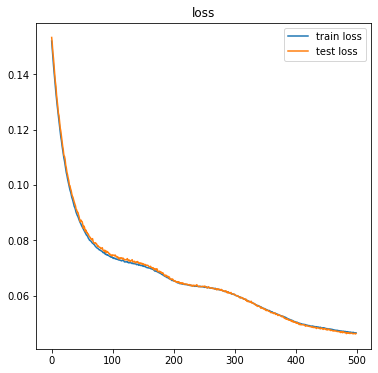

In [0]:
plt.figure(figsize=(6,6))

plt.plot(range(EPOCH), trainLoss)
plt.plot(range(EPOCH), testLoss)
plt.legend(['train loss', 'test loss'])
plt.title('loss')
plt.savefig("loss.png")

Plot the some output result of the network as an image.

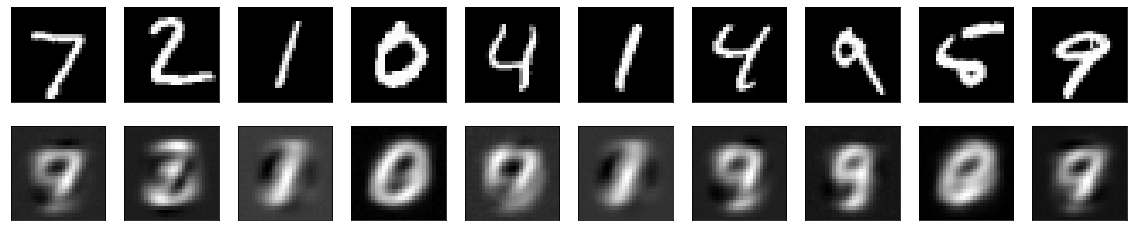

In [0]:
result_train = np.zeros((datasizeTrain, 1, 28, 28))
result_test = np.zeros((datasizeTest, 1, 28, 28))

#Get network output for train data.
for i in range(0, datasizeTrain, BATCH_SIZE):
    xBatch = dataTrain[i:i+BATCH_SIZE]
    if torch.cuda.is_available():
        xBatch = torch.from_numpy(xBatch.copy()).float().to('cuda')
    else:
        xBatch = torch.from_numpy(xBatch.copy()).float()
    re = net(xBatch)
    if torch.cuda.is_available():
        result_train[i:i+BATCH_SIZE] = re.to('cpu').data
    else:
        result_train[i:i+BATCH_SIZE] = re.data

#Get network output for test data.
for i in range(0, datasizeTest, BATCH_SIZE):
    xBatch = dataTest[i:i+BATCH_SIZE]
    if torch.cuda.is_available():
        xBatch = torch.from_numpy(xBatch.copy()).float().to('cuda')
    else:
        xBatch = torch.from_numpy(xBatch.copy()).float()
    re = net(xBatch)

    if torch.cuda.is_available():
        result_test[i:i+BATCH_SIZE] = re.to('cpu').data
    else:
        result_test[i:i+BATCH_SIZE] = re.data



n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(dataTest[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(result_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

View the plot of the hidden layer using PCA.

PCA is a technique for dimensional compression of multidimensional data.

The purpose of PCA is to find the principal component axis that maximizes the data variance and to represent the data along that axis.

If a data point projected the principal component axis is expressed $\bf{u}^T_1 x_i$, the variance of the projected data is as follows.

\begin{align}
Var[X] = \frac{1}{n}\sum_{i=1}^n (\bf{u_1}^T x_i - \bf{u_1}^T \bar{x})^2
\end{align}

Where $\bf{u}_1$ is the unit vector and $\bf{\bar{x}}$ is

\begin{align}
\bar{x} = \frac{1}{N}\sum_{n=1}^N \bf{x}_n
\end{align}

Also, $Var[X]$ can be expresed using the covariance $S = \frac{1}{N}\sum_{n=1}^N(\bf x_n-\bar{x})(x_n-\bar{x})^T$,

\begin{align}
var[X] = \bf u_1^T S u_1 ~~.
\end{align}

In order to consider dispersion maximization, a Lagrange constant is introduced into this equation.

\begin{align}
\bf u_1^T S u_1 + \lambda_1(1-u_1^Tu_1)
\end{align}

If the derivative with respect to u1 is 0,

In [0]:
from sklearn.decomposition import PCA